In [1]:
%matplotlib inline


Simple example of decoding: the Haxby data
==============================================

Here is a simple example of decoding, reproducing the Haxby 2001
study on a face vs cat discrimination task in a mask of the ventral
stream.


Retrieve and load the Haxby dataset


In [2]:
from nilearn import datasets
# if you download these from python.
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('First subject anatomical nifti image (3D) is at: %s' %
      haxby_dataset.anat[0])
print('First subject functional nifti images (4D) are at: %s' %
      haxby_dataset.func[0])  # 4D data

# Load the behavioral labels
import numpy as np
# Load target information as string and give a numerical identifier to each
labels = np.recfromcsv(haxby_dataset.session_target[0], delimiter=" ")

# scikit-learn >= 0.14 supports text labels. You can replace this line by:
# target = labels['labels']
_, target = np.unique(labels['labels'], return_inverse=True)

# Keep only data corresponding to faces or cats
condition_mask = np.logical_or(labels['labels'] == b'face',
                               labels['labels'] == b'cat')
target = target[condition_mask]


Dataset created in /Users/pp01sanne/nilearn_data/haxby2001



Downloaded 2969 of 2969 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 408 of 408 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 314803244 of 314803244 bytes (100.0%,    0.0s remaining) ...done. (721 seconds, 12 min)
Extracting data from /Users/pp01sanne/nilearn_data/haxby2001/b7061e6dfd4459484ab7c3872d37e765/subj1-2010.01.14.tar.gz..... done.


First subject anatomical nifti image (3D) is at: /Users/pp01sanne/nilearn_data/haxby2001/subj1/anat.nii.gz
First subject functional nifti images (4D) are at: /Users/pp01sanne/nilearn_data/haxby2001/subj1/bold.nii.gz


Prepare the data: apply the mask


In [3]:
from nilearn.input_data import NiftiMasker
# ventro-temporal mask -> it is a transformer -> 3D images => 2D feature spaces
mask_filename = haxby_dataset.mask_vt[0]
# For decoding, standardizing is often very important
nifti_masker = NiftiMasker(mask_img=mask_filename, standardize=True)

func_filename = haxby_dataset.func[0]
# We give the nifti_masker a filename and retrieve a 2D array ready
# for machine learning with scikit-learn
fmri_masked = nifti_masker.fit_transform(func_filename)

# Restrict the classification to the face vs cat discrimination
fmri_masked = fmri_masked[condition_mask]

In [11]:
print(fmri_masked.shape)
# it is a substantially reduced dataset.
print(fmri_masked)


print(target)

(216, 577)
[[-1.7471174   1.29787993 -0.22555825 ..., -1.59941506 -1.20669711
  -0.14274804]
 [-2.05748582  1.29787993 -0.19278905 ..., -1.63558471 -1.67683387
   0.22036591]
 [-2.15447593  1.48567474 -0.58601946 ..., -1.88877153 -2.02564502
   0.08832448]
 ..., 
 [-0.27286759 -0.29837653 -1.35609555 ...,  1.41471434  0.73451281
   1.70583212]
 [-0.05948933 -1.19979191 -1.99509501 ...,  1.24592304  0.78000987
   0.64950061]
 [-1.00999248 -0.6927458  -1.68378758 ...,  1.12535787  0.9468326
   1.30970788]]
[3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3
 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3
 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1]


The decoding


In [15]:
# Here we use a Support Vector Classification, with a linear kernel
from sklearn.svm import SVC

# set the kernel type
svc = SVC(kernel='linear')

# And we run it
print(target.shape)
print(fmri_masked.shape)
svc.fit(fmri_masked, target)
prediction = svc.predict(fmri_masked)
len(target)

(216,)
(216, 577)


216

Compute prediction scores using cross-validation


In [17]:
print(prediction);
print(target - prediction)

[3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3
 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3
 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [20]:
from sklearn.cross_validation import KFold

cv = KFold(n=len(fmri_masked), n_folds=5)
cv_scores = []

for train, test in cv:
    svc.fit(fmri_masked[train], target[train])
    prediction = svc.predict(fmri_masked[test])
    cv_scores.append(np.sum(prediction == target[test])
                     / float(np.size(target[test])))

print(cv_scores)

[0.72727272727272729, 0.46511627906976744, 0.72093023255813948, 0.58139534883720934, 0.7441860465116279]


Retrieve the discriminating weights and save them


In [21]:
# Retrieve the SVC discriminating weights
coef_ = svc.coef_

# Reverse masking thanks to the Nifti Masker
coef_img = nifti_masker.inverse_transform(coef_)

# Save the coefficients as a Nifti image
coef_img.to_filename('haxby_svc_weights.nii')

Visualize the discriminating weights over the mean EPI


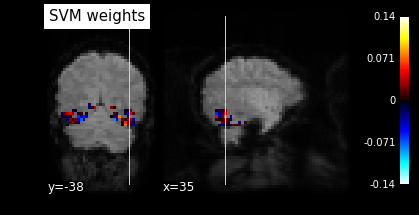

In [22]:
from nilearn.image import mean_img
from nilearn.plotting import plot_roi, plot_stat_map, show

mean_epi = mean_img(func_filename)
plot_stat_map(coef_img, mean_epi, title="SVM weights", display_mode="yx")

Plot also the mask that was computed by the NiftiMasker


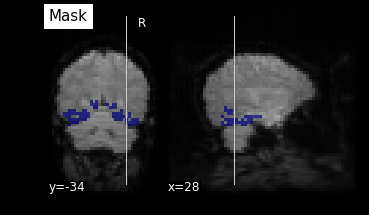

In [23]:
plot_roi(nifti_masker.mask_img_, mean_epi, title="Mask", display_mode="yx")

show()